In [ ]:
from Basefolder import basefolder
import time
import numpy as np
from Finder_1d import Finder_1d
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import seaborn as sns
from sklearn.cluster import DBSCAN
from Clustering_CAML import Clustering_CAML
import h5py
from DbscanLoop import DbscanLoop
from sklearn.neighbors import NearestNeighbors
import pickle
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

In [20]:
def PlotScatter(XC_,labels=[],ax=[]):

    if(len(labels)==0):
        labels = -1*np.ones((len(XC_),));
 
    if(ax==[]):
        fig,ax = plt.subplots(1,1,figsize=(6,6)); 
       
    mark_ = (labels==-1);
    ax.scatter(x=XC_[mark_,0],y=XC_[mark_,1],s=.4,c='grey',alpha=0.1);

    mark_ = (labels>=0);
    sns.scatterplot(x=XC_[mark_,0],y=XC_[mark_,1],hue=labels[mark_],palette='deep',linewidth=0,
                    s=2,legend=False,ax=ax);
    ax.set_aspect('equal');
#    plt.savefig(outputfolder+"results_"+analysis_name+"_"+filename_add+".pdf",bbox_inches="tight");

# Parameters

In [ ]:
analysis_name = "temp";
if(True):
    mainfolder = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/ProteinData_ttx_1hr_2/';
    filename     = mainfolder+'AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20.hdf5';
    outputfolder = mainfolder + 'ReferenceCheck/';

    datascale = 158; #=81/512*1000
    #Define window to analyse

    analysis_name = "dataWindow_2";
    xInt = [22000,27000];#30000
    yInt = [22000,27000];#30000      
    #xInt_params = [22000,27000];
    #yInt_params = [22000,27000];    
    
    analysis_name_ref = "noiseAnalysis_withReference_1";
    xInt_ref = [60000,70000];
    yInt_ref = [50000,60000];    
#    xInt_params = [22000,27000];
#    yInt_params = [22000,27000];

    #To study everything:
#    xInt = [0,np.Infinity];
#    yInt = [0,np.Infinity];
elif(False):
    outputfolder = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/MikeData/';
    filename     = outputfolder +'XC_red.txt'
    datascale    = 1; #=81/512*1000
    #Define window to analyse
    xInt = [0,np.Infinity];
    yInt = [0,np.Infinity];

# Load data

In [12]:
if(filename[-3:]=="txt"):
    XC = np.loadtxt(filename);
elif(filename[-4:]=="hdf5"):
#filename = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/ProteinData_ttx_1hr_2/AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20.hdf5';
    f             = h5py.File(filename, 'r')    
    dset          = f['locs'];
    XC            = np.stack((dset["x"],dset["y"])).T    

XC        = np.unique(XC,axis=0);
XC        = datascale*XC;

mark        = (XC[:,0]>xInt[0])*(XC[:,0]<xInt[1])*(XC[:,1]>yInt[0])*(XC[:,1]<yInt[1]);
mark_ref    = (XC[:,0]>xInt_ref[0])*(XC[:,0]<xInt_ref[1])*(XC[:,1]>yInt_ref[0])*(XC[:,1]<yInt_ref[1]);

In [5]:
if(False):
    FD      = Finder_1d(algo="DbscanLoop");
    labels  = FD.fit(XC[mark,:]);    
    
    FD_ref      = Finder_1d(algo="DbscanLoop");
    labels_ref  = FD.fit(XC[mark_ref,:],XC[mark,:]);    
    
    with open(outputfolder+"results_"+analysis_name+'.pickle','wb') as handle:
        pickle.dump({'FD':FD}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
else:
    with open(outputfolder+'results_dataWindow_2.pickle', 'rb') as fr:
        FD_load = pickle.load(fr);
    FD = FD_load['FD'];
    
    with open(outputfolder+'results_noiseAnalysis_withReference_1.pickle', 'rb') as fr:
        FD_load_ref = pickle.load(fr);
    FD_ref = FD_load_ref['FD'];

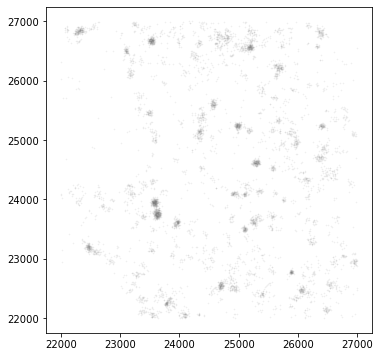

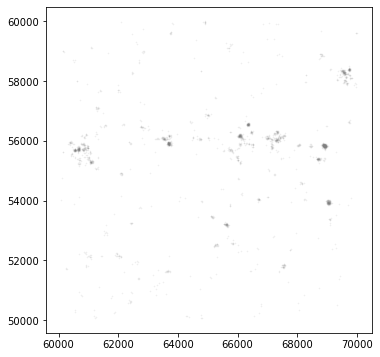

In [6]:
PlotScatter(XC[mark,:])
PlotScatter(XC[mark_ref,:])

# Analysis

In [120]:
#Select a clustering:
limit_noise_to_signal = 0.1;

df1     = FD.phasespace[['sigma', 'threshold','similarityScore','no_clusters']]
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore','no_clusters']]
df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);
df1['no_clusters_ref_ratio'] = (df1_ref['no_clusters'])/(df1['no_clusters']);

# (1) based on number of clusters
#df1     = FD.phasespace[['sigma', 'threshold','similarityScore']]
#df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]
#df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);
mark_ = (df1['similarityScore_ref_ratio'] < limit_noise_to_signal);
idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
print(df1.loc[idx_similarityScore,:])

# (1) based on number of clusters
#df1     = FD.phasespace[['sigma', 'threshold','no_clusters']]
#df1_ref = FD_ref.phasespace[['sigma', 'threshold','no_clusters']]
#df1['no_clusters_ref_ratio'] = (df1_ref['no_clusters'])/(df1['no_clusters']);
mark_ = (df1['no_clusters_ref_ratio'] < limit_noise_to_signal);
idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
print(df1.loc[idx_no_clusters,:])

sigma                          26.763500
threshold                      16.000000
similarityScore              1005.000000
no_clusters                    13.000000
similarityScore_ref_ratio       0.053731
no_clusters_ref_ratio           0.153846
Name: 65, dtype: float64
sigma                         16.527421
threshold                     11.000000
similarityScore              319.000000
no_clusters                    6.000000
similarityScore_ref_ratio      0.000000
no_clusters_ref_ratio          0.000000
Name: 21, dtype: float64


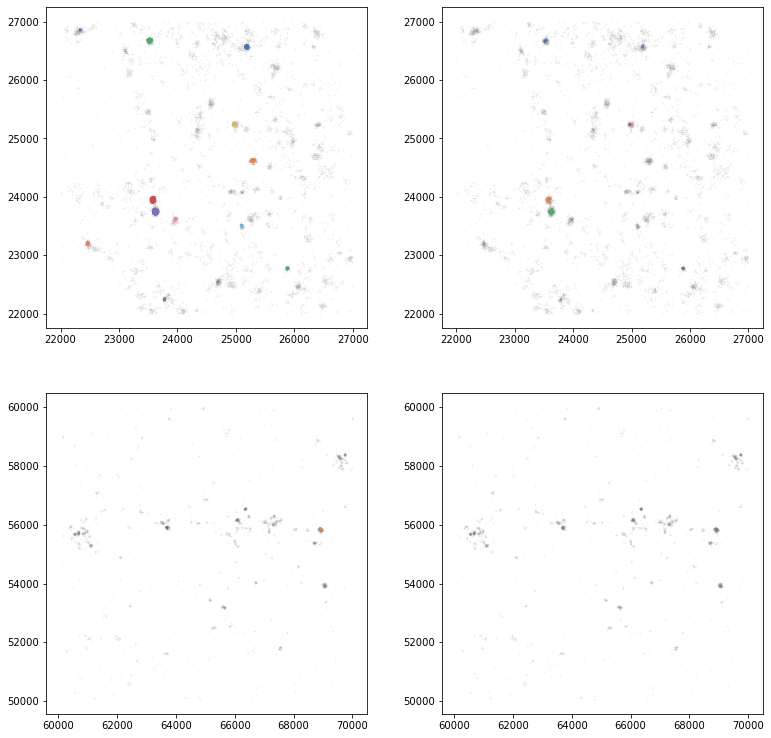

In [121]:
fig,axs = plt.subplots(2,2,figsize=(13,13)); 
PlotScatter(XC[mark,:],FD.phasespace.loc[idx_similarityScore,'labels'],ax=axs[0,0])
PlotScatter(XC[mark,:],FD.phasespace.loc[idx_no_clusters,'labels'],ax=axs[0,1])

PlotScatter(XC[mark_ref,:],FD_ref.phasespace.loc[idx_similarityScore,'labels'],ax=axs[1,0])
PlotScatter(XC[mark_ref,:],FD_ref.phasespace.loc[idx_no_clusters,'labels'],ax=axs[1,1])

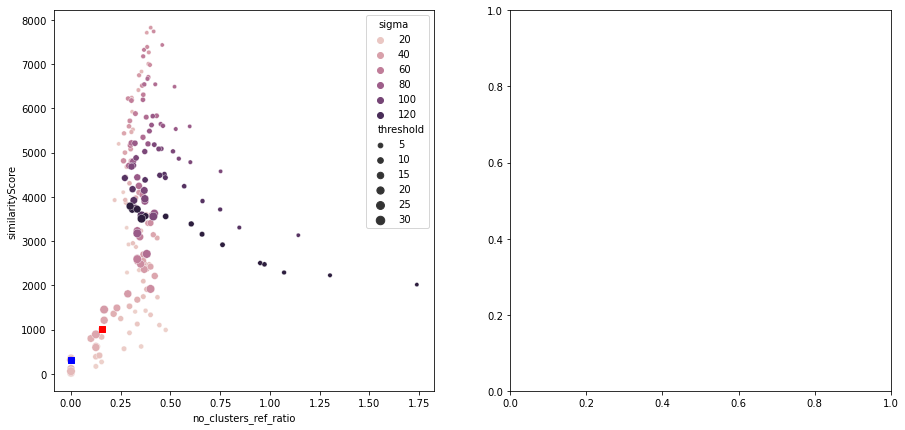

In [122]:

fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
#df1     = FD.phasespace[['sigma', 'threshold','similarityScore']]
#df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]
#df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);
sns.scatterplot(data=df1,x='no_clusters_ref_ratio',y="similarityScore",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref_ratio'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref_ratio'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
#ax.set_xlim(-10,2000);
#ax.set_ylim(-10,4000);


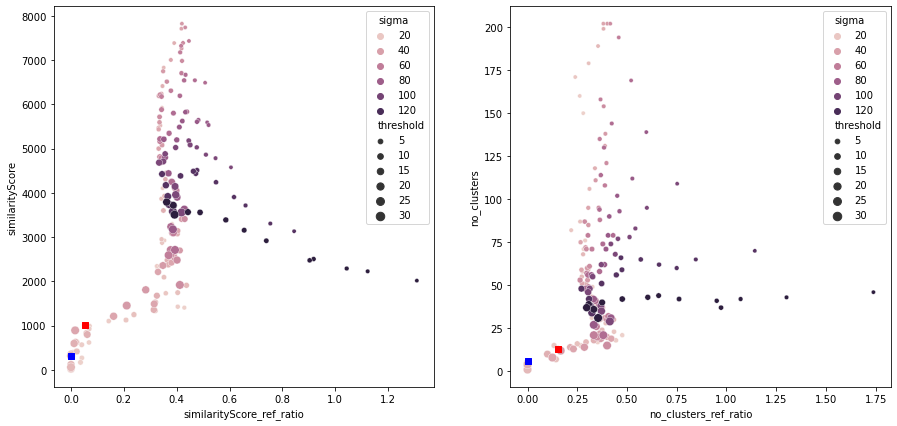

In [123]:

fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
#df1     = FD.phasespace[['sigma', 'threshold','similarityScore']]
#df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]
#df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);
sns.scatterplot(data=df1,x='similarityScore_ref_ratio',y="similarityScore",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref_ratio'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref_ratio'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
#ax.set_xlim(-10,2000);
#ax.set_ylim(-10,4000);

ax = axs[1];
#df1     = FD.phasespace[['sigma', 'threshold','no_clusters']]
#df1_ref = FD_ref.phasespace[['sigma', 'threshold','no_clusters']]
#df1['no_clusters_ref_ratio'] = (df1_ref['no_clusters'])/(df1['no_clusters']);

sns.scatterplot(data=df1,x='no_clusters_ref_ratio',y="no_clusters",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref_ratio'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref_ratio'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');


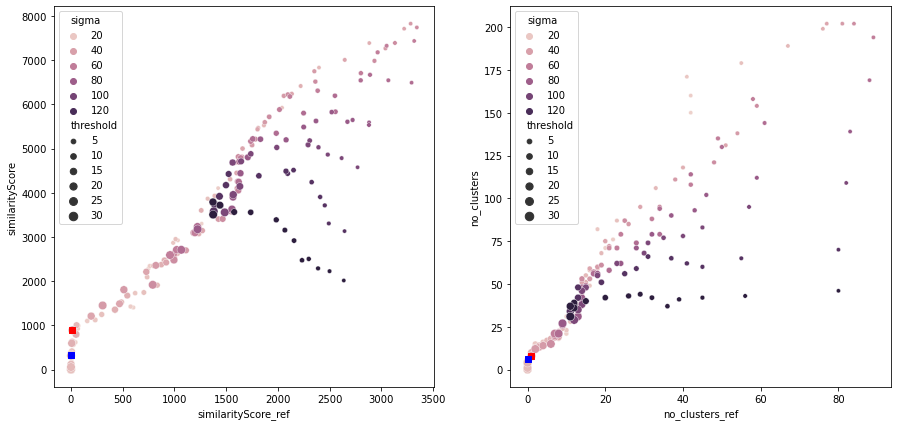

In [103]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
df1     = FD.phasespace[['sigma', 'threshold','similarityScore']]
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]
df1['similarityScore_ref'] = (df1_ref['similarityScore']).copy();
sns.scatterplot(data=df1,x='similarityScore_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');


#ax.set_xlim(-10,2000);
#ax.set_ylim(-10,4000);

ax = axs[1];
df1     = FD.phasespace[['sigma', 'threshold','no_clusters']]
df1_ref = FD_ref.phasespace[['sigma', 'threshold','no_clusters']]
df1['no_clusters_ref'] = (df1_ref['no_clusters']).copy();

sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');


#ax.set_xlim(-1,20);
#ax.set_ylim(-1,50);

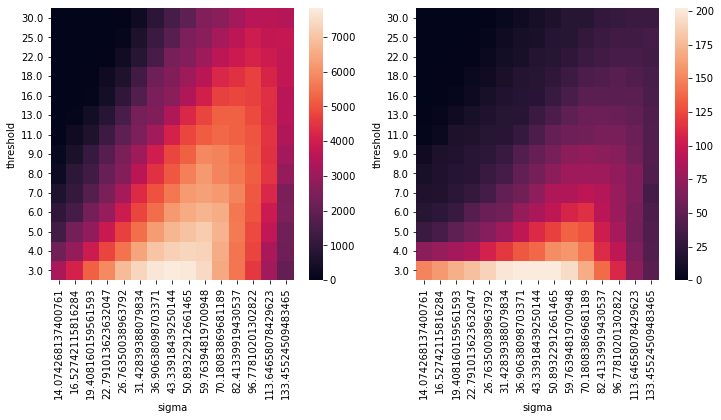

In [119]:
fig,axs = plt.subplots(1,2,figsize=(12,5));


heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1]);
ax.invert_yaxis()

In [ ]:

df1['no_clusters_diff'] = np.asarray(df1.loc[:,'no_clusters'])-np.asarray(df1_ref.loc[:,'no_clusters'])
df1 = df1.fillna(0)

fig,axs = plt.subplots(1,2,figsize=(12,5));

heatmap1_data = pd.pivot_table(df1, values='no_clusters_diff', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1]);
ax.invert_yaxis()

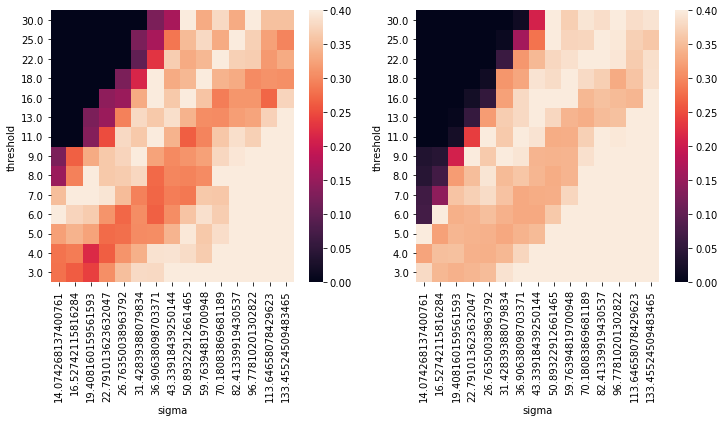

In [118]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
heatmap1_data = pd.pivot_table(df1, values='no_clusters_ref_ratio', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,vmin=0,vmax=0.4,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='similarityScore_ref_ratio', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,vmin=0,vmax=0.4,ax=axs[1]);
ax.invert_yaxis()
#plt.savefig(outputfolder+"results_"+analysis_name+"_no_clusters_ratio.pdf",bbox_inches="tight");

<ipython-input-112-d0afa147efb0>:3: RuntimeWarning: invalid value encountered in true_divide
  df1['similarityScore'] = np.asarray(df1_ref['similarityScore'])/np.asarray(df1['similarityScore']);


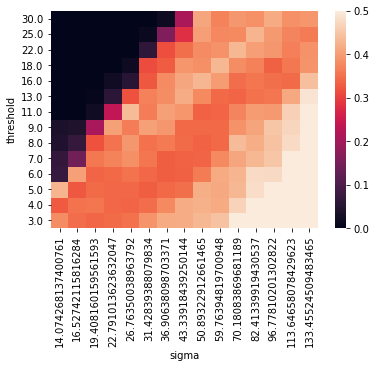

In [112]:
df1 = df1.fillna(0)

heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,vmin=0,vmax=0.5);
ax.invert_yaxis()
#plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore_ratio.pdf",bbox_inches="tight");

In [ ]:
df1 = FD_ref.phasespace[['sigma', 'threshold','no_clusters']]
heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
#plt.savefig(outputfolder+"results_"+analysis_name+"_noClusters.pdf",bbox_inches="tight");

In [ ]:
df1 = FD_ref.phasespace[['sigma', 'threshold','no_clusters']]
df1.loc[:,'no_clusters'] = df1.loc[:,'no_clusters']/np.max(df1.loc[:,'no_clusters']);
heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_noClusters_norm.pdf",bbox_inches="tight");

In [ ]:
df1 = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]
heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore.pdf",bbox_inches="tight");

In [ ]:
df1 = FD.phasespace[['sigma', 'threshold','similarityScore_mod']]
heatmap1_data = pd.pivot_table(df1, values='similarityScore_mod', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore_over_noise.pdf",bbox_inches="tight");

In [ ]:
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]

In [ ]:
np.asarray(df1['similarityScore'])

In [ ]:
df1['similarityScore'] = np.asarray(df1['similarityScore'])/np.asarray(df1_ref['similarityScore'])

In [ ]:
df1

In [ ]:
heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
#plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore_relative.pdf",bbox_inches="tight");

In [ ]:
heatmap1_data = pd.pivot_table(df1_ref, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore_relative.pdf",bbox_inches="tight");

In [ ]:
for th in np.unique(FD.phasespace['threshold']):
    mark = (FD.phasespace['threshold'] == th);
    PS_sel = FD.phasespace.loc[mark,:];
    idx_max = PS_sel['similarityScore'].idxmax();
    PlotScatter(PS_sel.loc[idx_max,'labels'],str(th));

In [ ]:
PS_sel.loc[:,'labels']